# **6-2. 자율주행 보조장치 (1) KITTI 데이터셋**

In [ ]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = '/content/object_detection/data'

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Shuffling /content/object_detection/data/kitti/3.2.0.incomplete1GATW2/kitti-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/423 [00:00<?, ? examples/s]

Shuffling /content/object_detection/data/kitti/3.2.0.incomplete1GATW2/kitti-validation.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/711 [00:00<?, ? examples/s]

Shuffling /content/object_detection/data/kitti/3.2.0.incomplete1GATW2/kitti-test.tfrecord*...:   0%|          …

Dataset kitti downloaded and prepared to /content/object_detection/data/kitti/3.2.0. Subsequent calls will reuse this data.


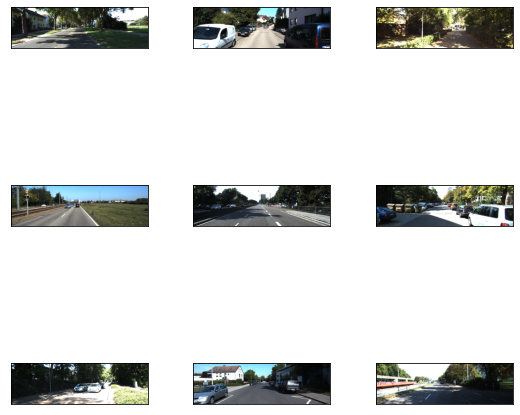

In [ ]:
_ = tfds.show_examples(ds_train, ds_info)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/content/object_detection/data/kitti/3.2.0',
    file_format=tfrecord,
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha

# **6-3. 자율주행 보조장치 (2) 데이터 직접 확인하기**

이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

In [1]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

NameError: ignored

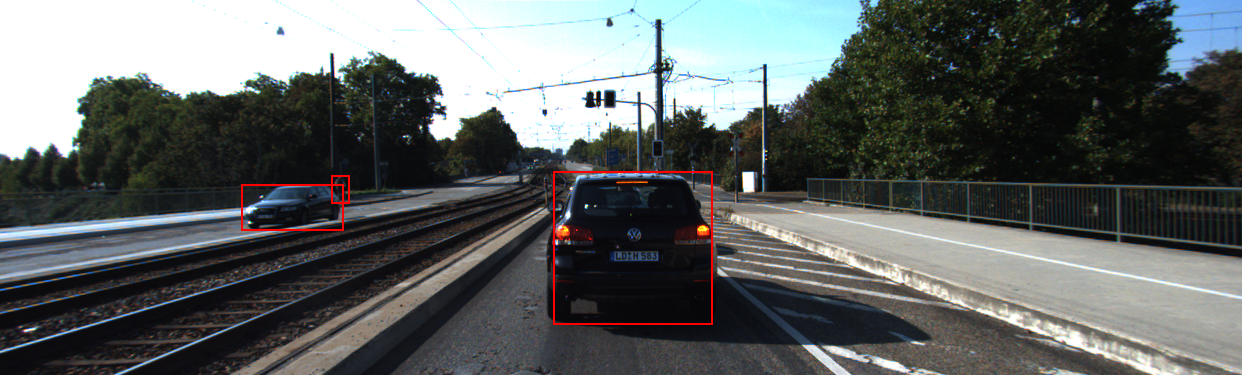

In [ ]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())


# **6-4. RetinaNet**


Focal Loss for Dense Object Detection
RetinaNet은 Focal Loss for Dense Object Detection 논문을 통해 공개된 detection 모델입니다.

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었습니다. 이를 해결하기 위해서 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용합니다.

Focal Loss
물체를 배경보다 더 잘 학습하자 == 물체인 경우 Loss를 작게 만들자

# 6-5. 데이터 준비

데이터 파이프 라인
먼저 주어진 KITTI 데이터를 학습에 맞는 형태로 바꾸어 주어야 합니다. 이때 사용할 데이터 파이프라인을 구축합니다.

데이터 파이프라인은 총 4단계로 이루어집니다.

x와 y좌표 위치 교체
무작위로 수평 뒤집기(Flip)
이미지 크기 조정 및 패딩 추가
좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [ ]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)



In [ ]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

In [ ]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

In [ ]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

In [ ]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

6-6. 모델 작성

In [ ]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

슝=3


In [ ]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

슝=3


우리가 만들 RetinaNet의 backbone은 ResNet50입니다. FPN에 이용할 수 있도록 중간 레이어도 output으로 연결해 줍니다.



In [ ]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

슝=3


In [ ]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

슝=3


이제 모델을 준비했고, Loss에 대한 준비를 해봅시다.

RetinaNet에서는 Focal Loss를 사용하는데요. Box Regression에는 사용하지 않고 Classification Loss를 계산하는데만 사용됩니다. Box Regression에는 Smooth L1 Loss를 사용했네요.

content img
[Focal Loss + Smooth L1 Loss]
https://arxiv.org/pdf/1708.02002.pdf
Smooth L1 Loss을 사용하는 Box Regression에는 delta를 기준으로 계산이 달라지고, Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의하세요!

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

슝=3


6-7. 모델 학습

In [ ]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

In [ ]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [ ]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

In [ ]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('슝=3')

In [ ]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

In [ ]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

In [ ]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

In [ ]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# **프로젝트: 자율주행 보조 시스템 만들기**

In [ ]:
import tensorflow as tf

print(tf.__version__)

1. 자율주행 시스템 만들기

위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

입력으로 이미지 경로를 받습니다.
정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
조건은 다음과 같습니다.
사람이 한 명 이상 있는 경우
차량의 크기(width or height)가 300px이상인 경우

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
        # 정지조건에 맞으면 return "Stop"
        # 아닌 경우 return "Go"

print(self_drive_assist(img_path))

2. 자율주행 시스템 평가하기

아래 test_system() 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [ ]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.

KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.
2. RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.

바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.
3. 자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.

테스트 수행결과 90% 이상의 정확도를 보였다.